In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import keras
%matplotlib inline

C:\Users\Vaibhav\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv('train_E6oV3lV.csv')

In [4]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [6]:
count_class_0, count_class_1 = df['label'].value_counts()

In [7]:
df_class_0 =  df.query('label==0')
df_class_1 =  df.query('label==1')

In [8]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1],ignore_index=True ,axis=0)

In [9]:
df_under.shape

(4484, 3)

In [10]:
df_under.groupby('label').count()

,id,tweet
label,,
0,2242,2242
1,2242,2242


In [11]:
X = df_under['tweet']
Y = df_under['label']
Y_org = Y

In [12]:
X[34]

" @user man rory didn't show up   #ufcottawa"

In [13]:
from keras.preprocessing.text import Tokenizer
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' ', lower=True, char_level=False, oov_token=None)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)

# add padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=400)

In [14]:
max(df['tweet'], key=len)

' @user lmfao pathetic #soit   #growup #funny #noonethere #iknowwhoitis ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98±ð\x9f\x98±ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98±ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f¤\x97ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82ð\x9f\x98\x82â\x80¦'

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit(X).transform(X)

C:\Users\Vaibhav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 95)
pca.fit(X)
X = pca.transform(X);

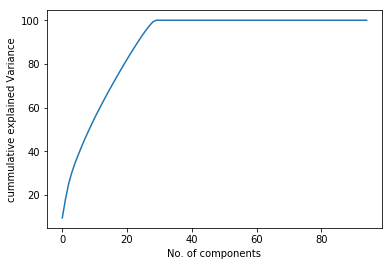

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state= 42)

In [19]:
from keras.models import Sequential 

In [20]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [21]:
classifier = Sequential()
classifier.add(LSTM(units=40, activation='relu',return_sequences= True, input_shape=(None, 95)))
classifier.add(Dropout(rate=0.3))

In [22]:
classifier.add(LSTM(units=20, return_sequences= True,activation='relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(LSTM(units=20,activation='relu'))
classifier.add(Dropout(rate=0.2))
classifier.add(Dense(units = 2, activation='sigmoid'))

In [23]:
classifier.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')

In [24]:
from sklearn.preprocessing import OneHotEncoder
y_e = OneHotEncoder()
Y_train_org = Y_train
Y_test_org = Y_test
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
y_e.fit(Y_train)
Y_train = y_e.transform(Y_train)
Y_test = y_e.transform(Y_test)

In [25]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0],1 ,X_test.shape[1]))
import tensorflow as tf
with tf.device('/gpu:0'):
    checker = classifier.fit(X_train_lstm, Y_train, batch_size=32, epochs=200, validation_data = (X_test_lstm, Y_test))


Train on 3587 samples, validate on 897 samples
Epoch 1/200
3587/3587 [==============================] - 6s 2ms/step - loss: 0.6922 - acc: 0.5659 - val_loss: 0.6891 - val_acc: 0.6945
Epoch 2/200
3587/3587 [==============================] - ETA: 0s - loss: 0.6813 - acc: 0.679 - 1s 282us/step - loss: 0.6811 - acc: 0.6774 - val_loss: 0.6619 - val_acc: 0.6996
Epoch 3/200
3587/3587 [==============================] - 1s 280us/step - loss: 0.6484 - acc: 0.6788 - val_loss: 0.6231 - val_acc: 0.7001
Epoch 4/200
3587/3587 [==============================] - 1s 314us/step - loss: 0.6384 - acc: 0.6873 - val_loss: 0.6137 - val_acc: 0.6968
Epoch 5/200
3587/3587 [==============================] - 1s 291us/step - loss: 0.6293 - acc: 0.6924 - val_loss: 0.6102 - val_acc: 0.6906
Epoch 6/200
3587/3587 [==============================] - 1s 375us/step - loss: 0.6216 - acc: 0.6915 - val_loss: 0.6084 - val_acc: 0.6990
Epoch 7/200
3587/3587 [==============================] - 1s 313us/step - loss: 0.6193 - acc: 0.

Epoch 60/200
3587/3587 [==============================] - 1s 253us/step - loss: 0.5179 - acc: 0.7579 - val_loss: 0.6468 - val_acc: 0.7352
Epoch 61/200
3587/3587 [==============================] - 1s 223us/step - loss: 0.5149 - acc: 0.7641 - val_loss: 0.6329 - val_acc: 0.7419
Epoch 62/200
3587/3587 [==============================] - 1s 247us/step - loss: 0.5151 - acc: 0.7732 - val_loss: 0.6320 - val_acc: 0.7369
Epoch 63/200
3587/3587 [==============================] - 1s 226us/step - loss: 0.5113 - acc: 0.7717 - val_loss: 0.6414 - val_acc: 0.7319
Epoch 64/200
3587/3587 [==============================] - 1s 215us/step - loss: 0.5163 - acc: 0.7644 - val_loss: 0.6342 - val_acc: 0.7425
Epoch 65/200
3587/3587 [==============================] - 1s 211us/step - loss: 0.5098 - acc: 0.7662 - val_loss: 0.6275 - val_acc: 0.7363
Epoch 66/200
3587/3587 [==============================] - 1s 227us/step - loss: 0.5045 - acc: 0.7689 - val_loss: 0.6259 - val_acc: 0.7419
Epoch 67/200
3587/3587 [==========

3587/3587 [==============================] - 1s 240us/step - loss: 0.4419 - acc: 0.8054 - val_loss: 0.7606 - val_acc: 0.7336
Epoch 120/200
3587/3587 [==============================] - 1s 225us/step - loss: 0.4410 - acc: 0.8089 - val_loss: 0.7547 - val_acc: 0.7414
Epoch 121/200
3587/3587 [==============================] - 1s 227us/step - loss: 0.4374 - acc: 0.8099 - val_loss: 0.7296 - val_acc: 0.7436
Epoch 122/200
3587/3587 [==============================] - 1s 226us/step - loss: 0.4299 - acc: 0.8132 - val_loss: 0.7550 - val_acc: 0.7453
Epoch 123/200
3587/3587 [==============================] - 1s 227us/step - loss: 0.4295 - acc: 0.8053 - val_loss: 0.7599 - val_acc: 0.7475
Epoch 124/200
3587/3587 [==============================] - 1s 228us/step - loss: 0.4350 - acc: 0.8078 - val_loss: 0.7293 - val_acc: 0.7447
Epoch 125/200
3587/3587 [==============================] - 1s 221us/step - loss: 0.4382 - acc: 0.8057 - val_loss: 0.7742 - val_acc: 0.7453
Epoch 126/200
3587/3587 [================

3587/3587 [==============================] - 1s 227us/step - loss: 0.4029 - acc: 0.8196 - val_loss: 0.8516 - val_acc: 0.7480
Epoch 179/200
3587/3587 [==============================] - 1s 244us/step - loss: 0.3957 - acc: 0.8231 - val_loss: 0.8753 - val_acc: 0.7475
Epoch 180/200
3587/3587 [==============================] - 1s 242us/step - loss: 0.3990 - acc: 0.8248 - val_loss: 0.8913 - val_acc: 0.7536
Epoch 181/200
3587/3587 [==============================] - 1s 224us/step - loss: 0.4038 - acc: 0.8187 - val_loss: 0.8718 - val_acc: 0.7559
Epoch 182/200
3587/3587 [==============================] - 1s 230us/step - loss: 0.4047 - acc: 0.8149 - val_loss: 0.8917 - val_acc: 0.7447
Epoch 183/200
3587/3587 [==============================] - 1s 229us/step - loss: 0.3947 - acc: 0.8244 - val_loss: 0.9165 - val_acc: 0.7480
Epoch 184/200
3587/3587 [==============================] - 1s 266us/step - loss: 0.3984 - acc: 0.8214 - val_loss: 0.9003 - val_acc: 0.7525
Epoch 185/200
3587/3587 [================

In [26]:
Y_pred_test_label = classifier.predict(X_test_lstm)
y_pred_test=np.argmax(Y_pred_test_label,axis =1)
y_pred_test
Y_pred_train_label = classifier.predict(X_train_lstm)
y_pred_train = np.argmax(Y_pred_train_label,axis=1)
Y_test_true = Y_test_org.astype(np.int)
Y_train_true = Y_train_org.astype(np.int)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_true,y_pred_test))

             precision    recall  f1-score   support

          0       0.77      0.74      0.76       443
          1       0.76      0.78      0.77       454

avg / total       0.76      0.76      0.76       897



In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
### for softmax function
print("TRAIN:  \n",confusion_matrix(y_pred_train,Y_train_true))
print("\nTest:  \n",confusion_matrix(y_pred_test,Y_test_true))

TRAIN:  
 [[1400  222]
 [ 399 1566]]

Test:  
 [[329  98]
 [114 356]]


In [30]:
print(classification_report(Y_train_true,y_pred_train))

             precision    recall  f1-score   support

          0       0.86      0.78      0.82      1799
          1       0.80      0.88      0.83      1788

avg / total       0.83      0.83      0.83      3587



In [31]:
classifier.save("rnn_classifier.h5")

In [32]:
from keras.models import load_model
new_model = load_model("rnn_classifier.h5")

In [33]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 40)          21760     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 40)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          4880      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 42        
Total para

In [34]:
new_model.get_weights()

[array([[-0.15638681, -0.05721815,  0.19148135, ...,  0.04406988,
         -0.16360393, -0.35887724],
        [ 0.3166293 ,  0.17514984, -0.13871841, ...,  0.21283135,
          0.40430394,  0.51955664],
        [ 0.32493255, -0.1303084 ,  0.07280492, ...,  0.08605286,
         -0.09871028, -0.2569402 ],
        ...,
        [ 0.002373  , -0.00099783,  0.06451716, ...,  0.13219467,
          0.04280247,  0.05158597],
        [ 0.01398076,  0.01039676,  0.11269689, ..., -0.06204052,
          0.06789814,  0.11017343],
        [-0.12271531,  0.03535141,  0.10404226, ...,  0.05649738,
         -0.05230553,  0.05346039]], dtype=float32),
 array([[ 0.07994584, -0.050658  , -0.06358485, ...,  0.03923859,
          0.04858167,  0.01616315],
        [ 0.00535981, -0.01240391,  0.0148801 , ...,  0.07670946,
          0.12110909, -0.10349266],
        [ 0.09330834,  0.06845205,  0.04006262, ...,  0.03643649,
          0.19453183, -0.14908938],
        ...,
        [-0.25845215, -0.01702788,  0.1

In [35]:
new_model.optimizer

In [36]:
new_model.predict(X_train_lstm)

array([[9.9995816e-01, 5.9688715e-05],
       [2.1278006e-01, 7.8744978e-01],
       [9.8046827e-01, 1.9982109e-02],
       ...,
       [1.6654980e-01, 8.3357579e-01],
       [1.7659269e-01, 8.2338834e-01],
       [3.5599971e-01, 6.4425606e-01]], dtype=float32)